# _evosim_ Simulator mode example 1: tumor evolution and progression
### In this example, we will evolve a heterogeneous tumor starting from a single cell, resect it upon detection, administer adjuvant therapy, and continue periodically monitoring it thereafter. This example showcases some of the main functionalities of the Simulator (single-run) mode.
Note: No pharmacokinetic modeling is used here, so that drug concentrations are assumed to reach all cells at their stated concentrations. Pharmacokinetic modeling can be implemented into the drug response if desired.

In [1]:
# import the Simulator module
from evosim import Simulator

# these are not necessary for evosim functionalities, but we will use them elsewhere in the 
#tutorial to visualize some of the results
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sim=Simulator()

We will simulate the growth of a tumor from a single cell. We will refer to this phenotype as 'A'. Here, we will assume that a maximum of 2 inheritable alterations can occur and hence the system can have up to 3 total cell phenotypes; we will refer to the mutant phenotypes as 'B' and 'C'.

We first need to define the initial population configuration:

In [4]:
initial_subpopulations = {'A':1,'B':0,'C':0}

We can choose to also specify the simulation method (extended-time leaping or the SSA) and the leaping threshold (for extended-time leaping). By default these parameters will default to leaping with a threshold of 10^2. We will go with the defaults here and initialize our population; see commented-out code for alternatives. 

We can also specify an environmental carrying capacity, which will lead to logistic growth at high population levels. By default this is set to 10^18 to avoid overflow errors.

By default, anything following the initialize() call will be saved to a default "results" folder, but if setting "new_folder" to True the results will be saved to a separate time-stamped folder. This is suggested when different configurations are of interest and multiple runs are expected.

In [5]:
sim.initialize(initial_subpopulations, carrying_capacity=10**12, new_folder=True)
#sim.initialize(initial_subpopulations)
#sim.initialize(pop_structure=initial_subpopulations)
#sim.initialize(initial_subpopulations, method='leaping')
#sim.initialize(initial_subpopulations, method='leaping',leap_threshold=10**3)
#sim.initialize(initial_subpopulations, method='SSA')

Now that we have specified the basic setup, we can set and change the rates that determine its evolution over time. The minimal information that we must specify at every stage of evolution are the birth (division) and death rates of each of the phenotypes allowable in the system ('A', 'B', and 'C') and the probabilities of mutation between them.

We will begin by assuming that as the tumor is growing B has a neutral advantage and C is somewhat disadvantaged through a lower birth rate. The rates that we specify must be in inverse expected time for a cell to divide (die). Here we will use days as our base time unit.

In [6]:
birth_rates={'A':0.004,'B':0.004,'C':0.003}
death_rates = {'A':0.0004,'B':0.0004,'C':0.0003}

Next, we must specify the probability of mutations, A->B, A->C, B->C, and the reverse. These probabilities represent the probability that a given mutation will occur in any particular cell division. Here we will assume that forward and backward mutations are just as likely, and that A->B is a more frequently occurring mutation that B->C or A->C.

In [7]:
MUT_PROB_AB=10**(-4) #mutation probability is probability of mutation occurring in a given division
MUT_PROB_AC=10**(-4)
MUT_PROB_BC=10**(-4)
mut_probs={'A': {'B': MUT_PROB_AB,'C':MUT_PROB_AC}, 'B': {'A':MUT_PROB_AB,'C':MUT_PROB_BC},\
           'C': {'A': MUT_PROB_AC,'B':MUT_PROB_BC}} #change if want fewer or more species

This is all the required information we need to set up the simulation, but we can also specify a detection threshold if we are interested in stopping the simulation at a certain total population size. This is useful for simulating tumors up to a certain size (at which point they may be clinically detectable). This stopping point is not exact, as there are multiple events taking place per leap and the population size is only checked every leap.

Lastly, we need to specify the total simulation time in the same units as the birth and death rates. Here we will evolve the tumor for 20 years or until it has reached a size of at least 10^9 cells. We will record the population distribution every year.

In [8]:
_,tumor_growth=sim.evolve(max_sim_time = 20*365,recording_interval = 365,birth_rates = birth_rates,\
                        death_rates=death_rates,mut_probs=mut_probs,detection_threshold=10**10)
#NOTE: calls to evolve() must use keyword arguments. This is the only such function in Simulator() and EnsembleSimulator().

This will generate a table of the different cell type population levels at each time point. Note that when starting from a single cell, some runs will result in the death of that cell without further evolution (as would be biologically expected), and hence due to stochasticity several runs may be needed in order to reach a critically growing tumor. To rerun, first rerun the initialize call, or the simulation will attempt to start at the zero-population level.

In [9]:
tumor_growth

,A,B,C
Time,,,
0.000000,1,0,0
365.000000,3,0,0
730.000000,19,0,0
1095.000000,75,0,0
1460.000000,304,0,0
1825.000000,1072,0,0
2190.000000,4027,3,0
2555.000000,15163,8,0
2920.000000,56477,29,8


But seeing decades in days isn't very helpful. Let's convert the time to years.

In [10]:
sim.convert_time(tumor_growth,'days_to_years')

,A,B,C
Time,,,
0.000000,1,0,0
1.000000,3,0,0
2.000000,19,0,0
3.000000,75,0,0
4.000000,304,0,0
5.000000,1072,0,0
6.000000,4027,3,0
7.000000,15163,8,0
8.000000,56477,29,8


Let's look at the total population after this simulation:

In [11]:
sim.pop_total()

10072283264

Or the distribution at the last time point:

In [12]:
sim.pop_distribution()

{'A': 10046106144, 'B': 21838705, 'C': 4338415}

We can also compute the current diversity of the population according to a selected diversity index.

In [13]:
print('Current Shannon index is ',sim.diversity('shannon'))
print('Current Simpson index is ',sim.diversity('simpson'))
print('Current Gini-Simpson index is ',sim.diversity('gini-simpson'))
print('Current Gini index is ',sim.diversity('gini'))
print('Current Renyi entropy for q=3 is ',sim.renyi_entropy(3))
print('Current Renyi entropy for q=7 is ',sim.renyi_entropy(7))

Current Shannon index is  0.019233123729014256
Current Simpson index is  0.9948137887988967
Current Gini-Simpson index is  0.005186211201103297
Current Gini index is  0.6646468972194838
Current Renyi entropy for q=3 is  0.0039034586009567226
Current Renyi entropy for q=7 is  0.0030360273825841295


If this is the size of the tumor detected, then we might want to resect it prior to treatment. If we think there may be some small residual cell population of e.g. 0.01% of the original population, we can use the perform_dilution function to sample it, where we input the final population. Let's suppose the resection takes a couple of hours, so that we set the actual time that the dilution takes to 0.1 days.

In [14]:
sim.perform_dilution(0.0001*sim.pop_total(),dilution_time=0.1)

We can see the population is much smaller now:

In [15]:
sim.pop_total()

1007228

In [16]:
sim.pop_distribution()

{'A': 1004691, 'B': 2128, 'C': 409}

We can now administer adjuvant treatment. Suppose that we use two drugs in combination, a drug which has the effect of increasing the cell death rates and a drug that affects the division rates. We will assume a simple Hill-type dependence on the drug concentration C (at the tumor), in arbitrary drug units, in the case of the birth rate, and the dependence shown below for the death rates.

In [18]:
def Hill_eqn(C,IC50,n):
    return 1/(1+(C/IC50)**n)
def drug_birth_rate(drug_free_birth_rate,C,IC50,n):
    return drug_free_birth_rate*Hill_eqn(C,IC50,n)
def drug_death_rate(drug_free_death_rate,C,IC50,n):
    return drug_free_death_rate*(1+C/IC50)**n

Let's plot the dose-response curve for a few different choices of Hill exponent, while noting that this is for birth/death rates only rather than total growth.

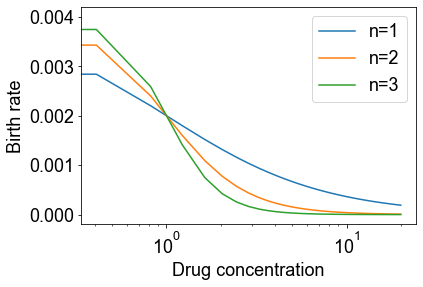

In [19]:
drug_concentrations=np.linspace(0,20,50)
drug_response_1=[drug_birth_rate(birth_rates['A'],c,1,1) for c in drug_concentrations]
drug_response_2=[drug_birth_rate(birth_rates['A'],c,1,2) for c in drug_concentrations]
drug_response_3=[drug_birth_rate(birth_rates['A'],c,1,3) for c in drug_concentrations]
plt.plot(drug_concentrations,drug_response_1,label='n=1')
plt.plot(drug_concentrations,drug_response_2,label='n=2')
plt.plot(drug_concentrations,drug_response_3,label='n=3')
plt.xscale('log')
plt.legend()
plt.xlabel('Drug concentration')
plt.ylabel('Birth rate')
plt.show()

We will stick with n=3 here. Let's look at how different values of IC50 (sensitivity) affect the birth rate for type A.

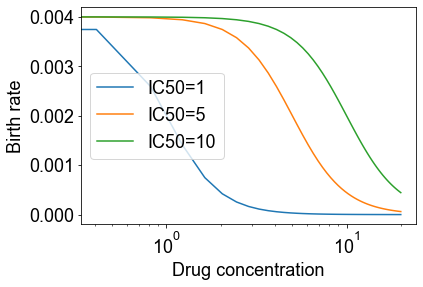

In [20]:
drug_concentrations=np.linspace(0,20,50)
drug_response_1=[drug_birth_rate(birth_rates['A'],c,1,3) for c in drug_concentrations]
drug_response_2=[drug_birth_rate(birth_rates['A'],c,5,3) for c in drug_concentrations]
drug_response_3=[drug_birth_rate(birth_rates['A'],c,10,3) for c in drug_concentrations]
plt.plot(drug_concentrations,drug_response_1,label='IC50=1')
plt.plot(drug_concentrations,drug_response_2,label='IC50=5')
plt.plot(drug_concentrations,drug_response_3,label='IC50=10')
plt.xscale('log')
plt.legend()
plt.xlabel('Drug concentration')
plt.ylabel('Birth rate')
plt.show()

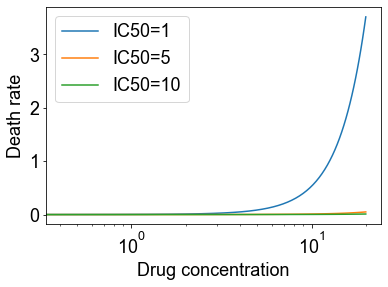

In [21]:
drug_concentrations=np.linspace(0,20,50)
drug_response_1=[drug_death_rate(death_rates['A'],c,1,3) for c in drug_concentrations]
drug_response_2=[drug_death_rate(death_rates['A'],c,5,3) for c in drug_concentrations]
drug_response_3=[drug_death_rate(death_rates['A'],c,10,3) for c in drug_concentrations]
plt.plot(drug_concentrations,drug_response_1,label='IC50=1')
plt.plot(drug_concentrations,drug_response_2,label='IC50=5')
plt.plot(drug_concentrations,drug_response_3,label='IC50=10')
plt.xscale('log')
plt.legend()
plt.xlabel('Drug concentration')
plt.ylabel('Death rate')
plt.show()

Let's assume in the following that types A and B are equally sensitive to the drugs, with IC50=1 for both drugs, but that C is more resistant to the drug affecting birth rates (with IC50=5) and completely resistant to the drug affecting death rates (IC50=100). Let's simulate what happens after we administer adjuvant therapy at C=1 for both drugs.

In [23]:
cell_types=list(sim.pop_distribution().keys())
print(cell_types)
IC50_levels_targeted_drug={'A':1,'B':1,'C':10}
IC50_levels_chemo={'A':1,'B':1,'C':100}
concentration_targeted=5
concentration_chemo=5
new_birth_rates={cell_type:drug_birth_rate(birth_rates[cell_type],concentration_targeted,\
                                           IC50_levels_targeted_drug[cell_type],3) for cell_type in cell_types}
print('birth rates with drugs: ',new_birth_rates)
new_death_rates={cell_type:drug_death_rate(death_rates[cell_type],concentration_chemo,\
                                           IC50_levels_chemo[cell_type],3) for cell_type in cell_types}
print('death rates with drugs: ',new_death_rates)

['A', 'B', 'C']
birth rates with drugs:  {'A': 3.1746031746031745e-05, 'B': 3.1746031746031745e-05, 'C': 0.0026666666666666666}
death rates with drugs:  {'A': 0.0864, 'B': 0.0864, 'C': 0.0003472875}


We will now administer this combination treatment over 6 months, recording every month.

In [24]:
_,adjuvant=sim.evolve(max_sim_time = 30*6,recording_interval = 30,birth_rates = new_birth_rates,\
                    death_rates=new_death_rates,mut_probs=mut_probs)

In [25]:
adjuvant

,A,B,C
Time,,,
6283.284261,1004691,2128,409
6313.284261,75196,157,433
6343.284261,5629,12,462
6373.284261,404,0,503
6403.284261,30,0,547
6433.284261,5,0,588
6463.284261,1,0,631


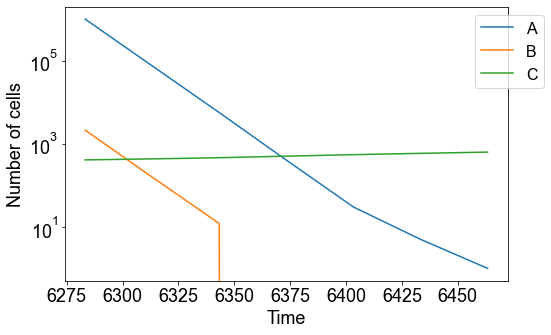

In [26]:
sim.plot_any_time_course_clonal(adjuvant,scale='log')

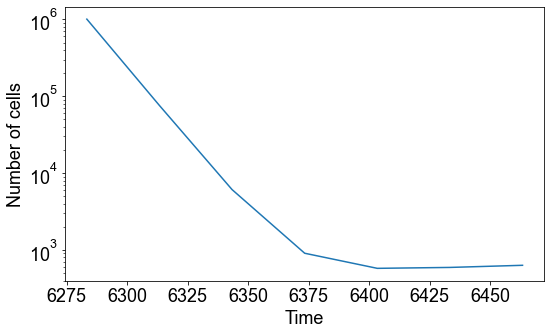

In [27]:
sim.plot_any_time_course_total(adjuvant,scale='log')

In [28]:
sim.pop_total()

632

At this point, the population is low enough that we are very unlikely to be able to see any remaining tumor cells. So we stop the adjuvant therapy and keep monitoring the patient. Let's keep checking on the patient once every 6 months for the next 20 years. This time, since the patient is under observation, we will set a detection limit of 10^7 cells.

In [29]:
_,post_adjuvant=sim.evolve(max_sim_time = 15*365,recording_interval = 6*30,birth_rates = birth_rates,death_rates=death_rates,\
           mut_probs=mut_probs,detection_threshold=10**7)

In [30]:
sim.pop_total()

10050556

In [31]:
sim.convert_time(post_adjuvant,'days_to_years')

,A,B,C
Time,,,
17.707628,1,0,631
18.200779,6,0,982
18.693929,16,0,1636
19.187080,28,0,2739
19.680231,48,0,4437
20.173382,75,0,7319
20.666532,150,0,11949
21.159683,280,1,19537
21.652834,527,3,31690


So in this case there was a recurrence after 9 years that is now largely resistant to the two original drugs that we used. Let's have a look at the entire time course from tumor initiation through the recurrence detection:

In [32]:
sim.convert_time(sim.get_full_time_course(),'days_to_years')

,A,B,C
Time,,,
0.000000,1,0,0
1.000000,3,0,0
2.000000,19,0,0
3.000000,75,0,0
4.000000,304,0,0
5.000000,1072,0,0
6.000000,4027,3,0
7.000000,15163,8,0
8.000000,56477,29,8


We can plot this time course (as well as any part of it - see documentation for details):

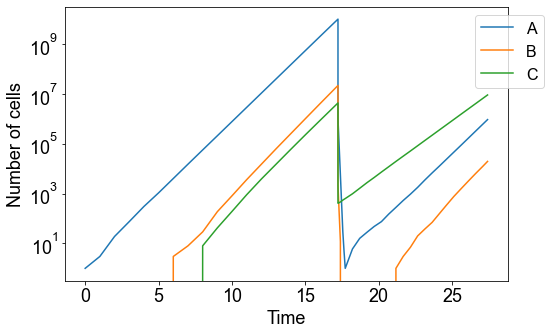

In [33]:
sim.plot_full_time_course_clonal(scale='log',time_conversion='days_to_years')

We can see clearly that resection with adjuvant therapy reduced the overall tumor population, but since there was a residual C population after adjuvant therapy, these cells kept growing, eventually also giving rise to A and B cells via mutations, and dominating the tumor when the recurrence is finally detected 9 years after the termination of adjuvant therapy.

Let's look at how the diversity changed over time.

In [34]:
shannon_df=sim.convert_time(sim.diversity_full_time_course(index='shannon'),'days_to_years')
simpson_df=sim.convert_time(sim.diversity_full_time_course(index='simpson'),'days_to_years')
gini_simpson_df=sim.convert_time(sim.diversity_full_time_course(index='gini-simpson'),'days_to_years')
gini_df=sim.convert_time(sim.diversity_full_time_course(index='gini'),'days_to_years')

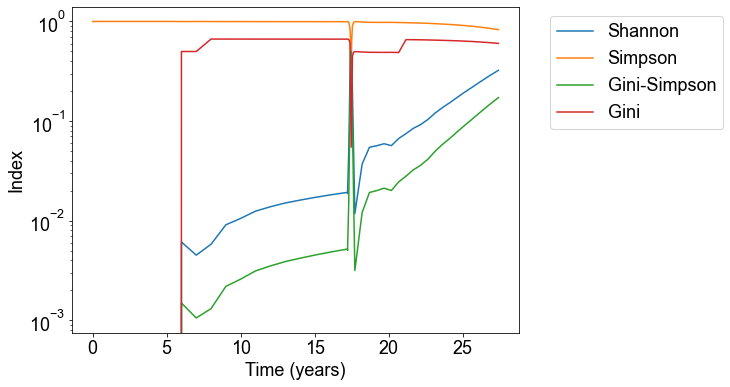

In [35]:
plt.figure(figsize=(8,6))
plt.plot(shannon_df.index,shannon_df['shannon'],label='Shannon')
plt.plot(simpson_df.index,simpson_df['simpson'],label='Simpson')
plt.plot(gini_simpson_df.index,gini_simpson_df['gini-simpson'],label='Gini-Simpson')
plt.plot(gini_df.index,gini_df['gini'],label='Gini')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('Time (years)')
plt.ylabel('Index')
plt.yscale('log')
plt.show()

Or we can plot them each separately:

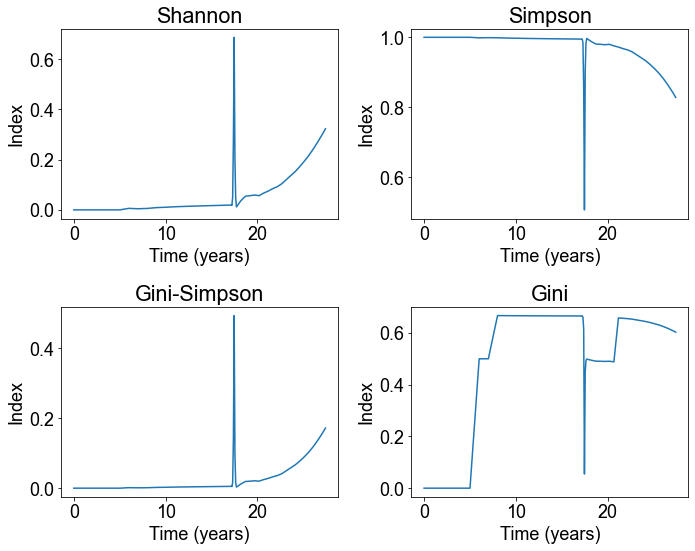

In [36]:
fig, axs = plt.subplots(2, 2,figsize=(10,8))
axs[0, 0].plot(shannon_df.index,shannon_df['shannon'])
axs[0, 0].set_title('Shannon')
axs[0, 1].plot(simpson_df.index,simpson_df['simpson'])
axs[0, 1].set_title('Simpson')
axs[1, 0].plot(gini_simpson_df.index,gini_simpson_df['gini-simpson'])
axs[1, 0].set_title('Gini-Simpson')
axs[1, 1].plot(gini_df.index,gini_df['gini'])
axs[1, 1].set_title('Gini')

for ax in axs.flat:
    ax.set(xlabel='Time (years)', ylabel='Index')
    #ax.set_yscale('log')

plt.tight_layout()
plt.show()